In [1]:
import os
import sys
import re
from matplotlib import pyplot as plt
from coffea.util import load
from omegaconf import OmegaConf
import numpy as np
import awkward as ak
from pocket_coffea.utils.plot_utils import PlotManager
import argparse
import mplhep as hep

hep.style.use("CMS")


In [2]:
var_name_dict={
                'u_perp_resolution': r'$\sigma u_{\perp}$ [GeV]',
            'u_perp_scaled_resolution': r'$\sigma u_{\perp} scaled$ [GeV]',
            'u_par_resolution': r'$\sigma u_{\parallel}$ [GeV]',
            'u_par_scaled_resolution': r'$\sigma u_{\parallel} scaled$ [GeV]',
            'R': r'-$<u_{||}>/<q_{T}>$',
}

In [3]:
def create_histos(qT_arr, resolutions_arr):
    # compute mean of all metrics in summary
    max_x=200 # max qT value
    x_n=20 #number of bins

    bin_edges=np.arange(0, max_x, 10)
    inds=np.digitize(qT_arr,bin_edges)
    print(inds[inds>7])
    qT_hist=[]
    for i in range(1, len(bin_edges)):
        qT_hist.append((bin_edges[i]+bin_edges[i-1])/2.)
    
    resolution_hists={}
    for key in resolutions_arr:
        print(key)
        R_arr=resolutions_arr[key][2] 
        u_perp_arr=resolutions_arr[key][0]
        u_par_arr=resolutions_arr[key][1]
        
        print(R_arr, len(R_arr))
        print(u_perp_arr, len(u_perp_arr))
        print(u_par_arr, len(u_par_arr))

        u_perp_hist=[]
        u_perp_scaled_hist=[]
        u_par_hist=[]
        u_par_scaled_hist=[]
        R_hist=[]

        for i in range(1, len(bin_edges)):
            R_i=R_arr[np.where(inds==i)[0]]
            R_hist.append(np.mean(R_i))
            u_perp_i=u_perp_arr[np.where(inds==i)[0]]
            u_perp_scaled_i=u_perp_i/np.mean(R_i)
            u_perp_hist.append((np.quantile(u_perp_i,0.84)-np.quantile(u_perp_i,0.16))/2.)
            u_perp_scaled_hist.append((np.quantile(u_perp_scaled_i,0.84)-np.quantile(u_perp_scaled_i,0.16))/2.)
            u_par_i=u_par_arr[np.where(inds==i)[0]]
            u_par_scaled_i=u_par_i/np.mean(R_i)
            u_par_hist.append((np.quantile(u_par_i,0.84)-np.quantile(u_par_i,0.16))/2.)
            u_par_scaled_hist.append((np.quantile(u_par_scaled_i,0.84)-np.quantile(u_par_scaled_i,0.16))/2.)

        u_perp_resolution=np.histogram(qT_hist, bins=x_n, range=(0,max_x), weights=u_perp_hist)
        u_perp_scaled_resolution=np.histogram(qT_hist, bins=x_n, range=(0,max_x), weights=u_perp_scaled_hist)
        u_par_resolution=np.histogram(qT_hist, bins=x_n, range=(0,max_x), weights=u_par_hist)
        u_par_scaled_resolution=np.histogram(qT_hist, bins=x_n, range=(0,max_x), weights=u_par_scaled_hist)
        R=np.histogram(qT_hist, bins=x_n, range=(0,max_x), weights=R_hist)
        resolution_hists[key] = {
            'u_perp_resolution': u_perp_resolution,
            'u_perp_scaled_resolution': u_perp_scaled_resolution,
            'u_par_resolution': u_par_resolution,
            'u_par_scaled_resolution':u_par_scaled_resolution,
            'R': R
        }
    return resolution_hists

In [4]:
def plot_histos(histo_dict):
    for var_name in ['u_perp_resolution', 'u_perp_scaled_resolution', 'u_par_resolution', 'u_par_scaled_resolution', 'R']:
        fig, ax = plt.subplots()
        for key in histo_dict:
            ax.errorbar(histo_dict[key][var_name][1][:-1], histo_dict[key][var_name][0], label=key, fmt=".",)
        ax.legend()
        ax.set_xlabel(r'Z q$_{\mathrm{T}}$ [GeV]')
        ax.set_ylabel(var_name if var_name not in var_name_dict else var_name_dict[var_name])
        hep.cms.lumitext(r"(13.6 TeV)", ax=ax)
        hep.cms.text(text="Simulation Preliminary", ax=ax)
        # fig.savefig(f'{var_name}.png')
        # plt.close(fig)
        fig.show()

In [5]:
input_dir = "/work/mmalucch/out_jme/DY_MET_NoStandardJEC/"
inputfile = os.path.join(input_dir, "output_all.coffea")
outputdir = os.path.join(input_dir, "plots_comparison")
accumulator = load(inputfile)
sample = list(accumulator["columns"].keys())[0]
dataset = list(accumulator["columns"][sample].keys())[0]
category = list(accumulator["columns"][sample][dataset].keys())[0]

col_dict={}
for var in accumulator["columns"][sample][dataset][category]:
    col_dict[var]=accumulator["columns"][sample][dataset][category][var].value

v_qT=col_dict["ll_pt"]

resolutions_arr={}

for var in col_dict:
    if "_MuonGood" in var and any(x in var for x in ["u_perp_predict", "u_paral_predict", "response"]):
        coll=var.split("_")[0]
        if coll not in resolutions_arr:
            resolutions_arr[coll]=[]
        print(var)
        resolutions_arr[coll].append(col_dict[var])





PuppiMET_MuonGood_u_perp_predict
PuppiMET_MuonGood_u_paral_predict
PuppiMET_MuonGood_response
PuppiMETPNet_MuonGood_u_perp_predict
PuppiMETPNet_MuonGood_u_paral_predict
PuppiMETPNet_MuonGood_response
PuppiMETPNetPlusNeutrino_MuonGood_u_perp_predict
PuppiMETPNetPlusNeutrino_MuonGood_u_paral_predict
PuppiMETPNetPlusNeutrino_MuonGood_response


[9 8 8 ... 8 8 8]
PuppiMET
[ 1.01806381 -0.16613142  4.40397614 ... -2.77915042 -0.17216193
  2.54426908] 3495587
[ 7.59101948 26.98777161 20.94832473 ... 23.79301488 11.03947296
  6.99567617] 3495587
[  1.12025555 -18.82854879   7.55024528 ...   4.17276866  -6.14135419
  12.02101235] 3495587
PuppiMETPNet
[ 1.12361772 -0.11519656  3.66357219 ... -2.55518664 -0.33684331
  2.59156926] 3495587
[ 8.37680983 31.20971913 24.30689    ... 23.98398345 15.89143974
  8.45358149] 3495587
[  7.66634712 -19.97864566   5.90798012 ...   3.6474904   -4.91965789
  12.38920985] 3495587
PuppiMETPNetPlusNeutrino
[ 1.1210229  -0.10634289  3.66868349 ... -2.5317174  -0.34299467
  2.61310189] 3495587
[ 8.5295992  31.55746542 24.32680625 ... 23.99983276 16.27410441
  8.31515637] 3495587
[  7.50542539 -20.17855938   5.91931732 ...   3.5924463   -4.87402378
  12.5568257 ] 3495587


/tmp/ipykernel_1900/3173316054.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


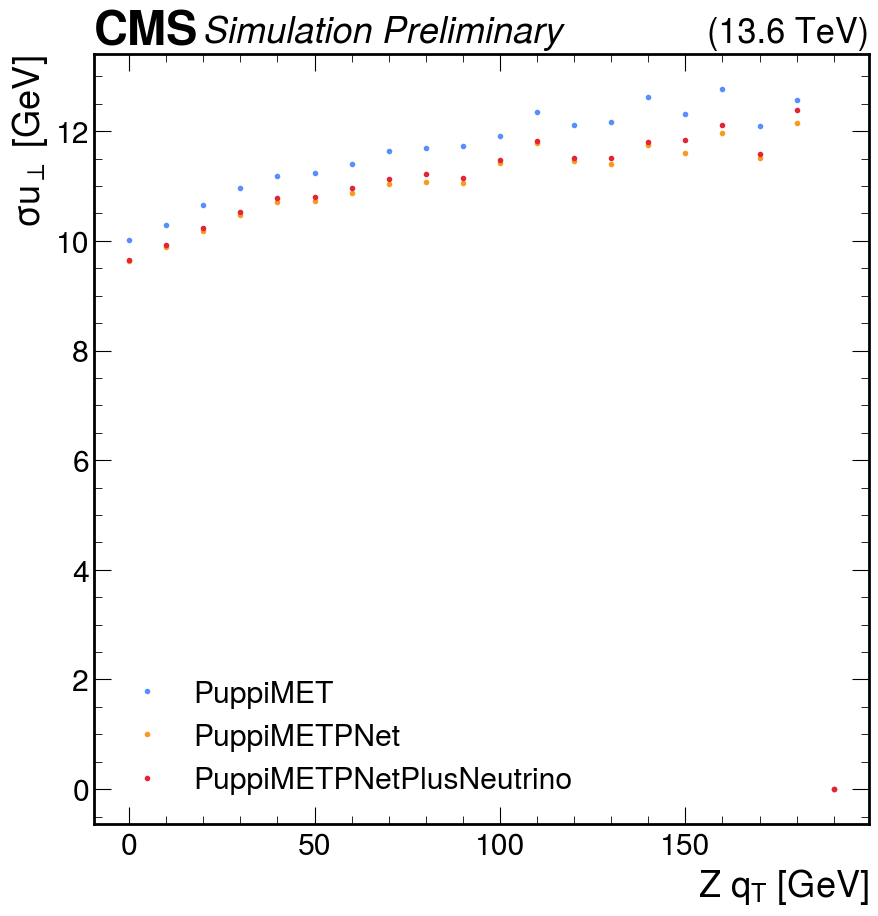

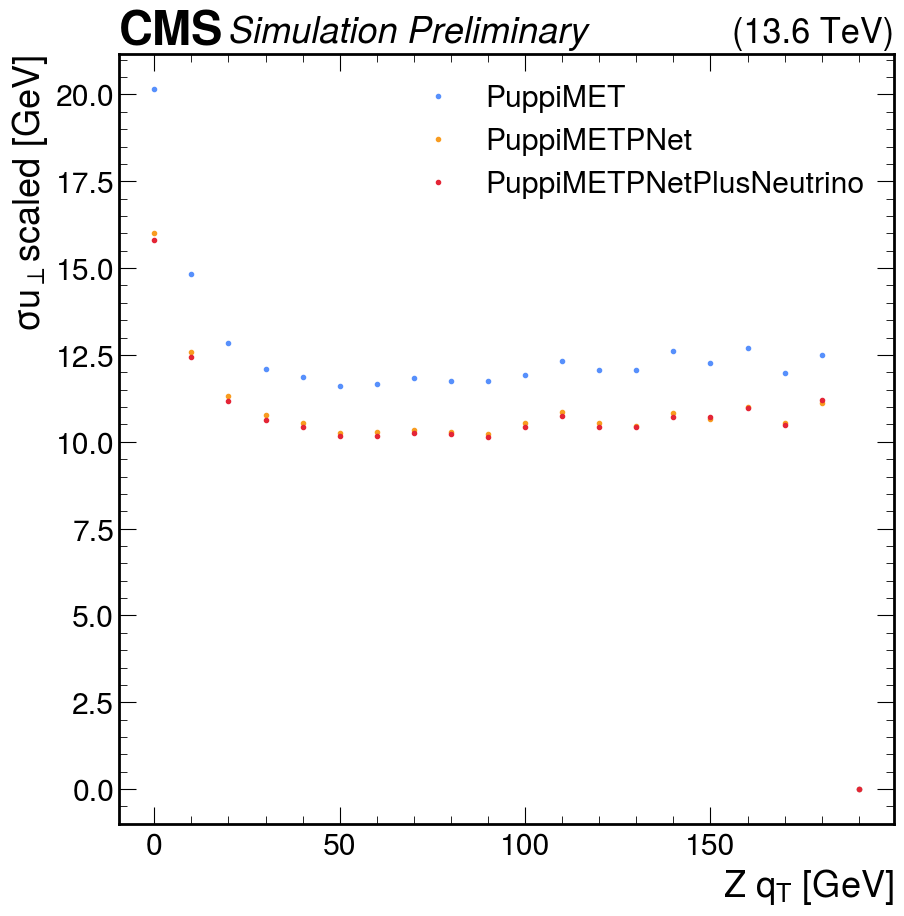

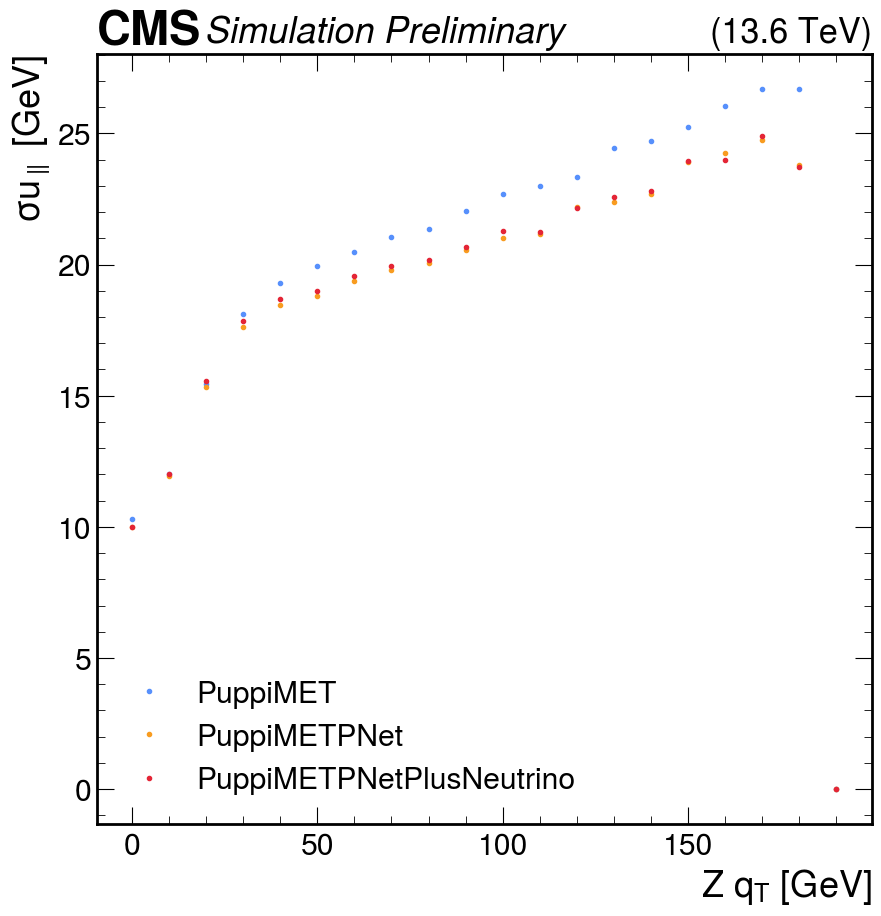

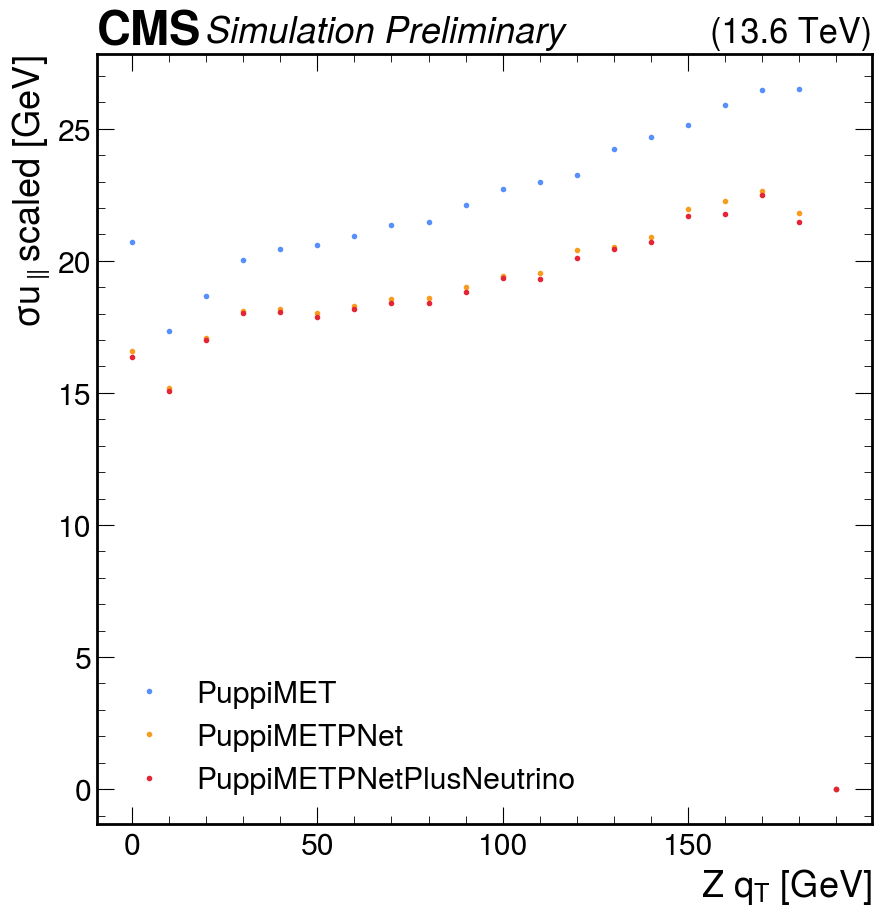

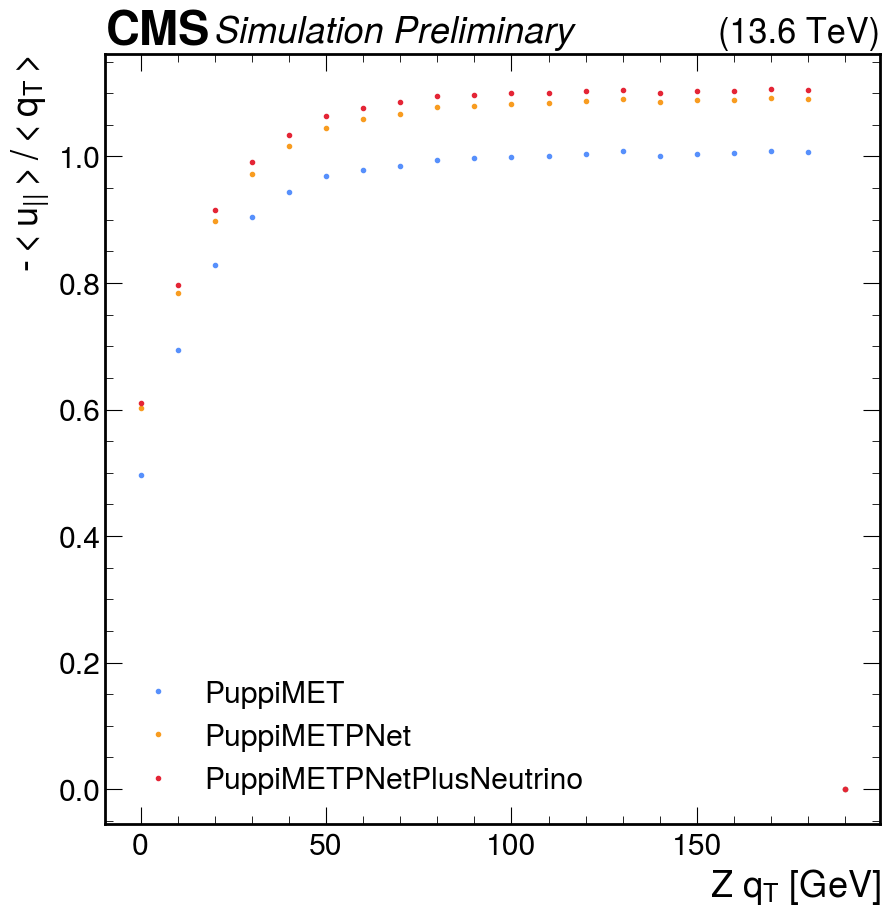

In [6]:
resolution_hists=create_histos(v_qT, resolutions_arr)
plot_histos(resolution_hists)